# Machine Learning Part
* goal of this notebook is to develop code for the machine learning portion
    * dataset loading
    * model
    * evaluation metrics
* code should be added into qdanalysis and refactored aferwards

In [17]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

In [28]:
data = keras.preprocessing.image_dataset_from_directory('output/cerug_test_processing/', label_mode='int')
data

Found 5224 files belonging to 2 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


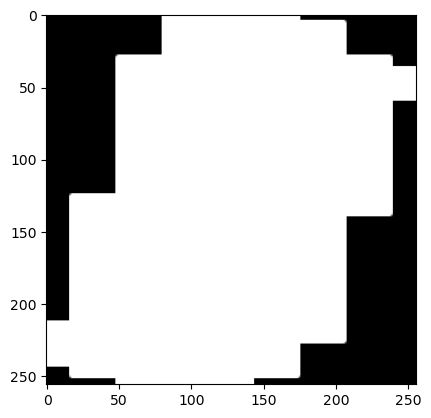

In [29]:
instan = data.take(1)

for image_batch, label_batch in instan:
    image = image_batch[0]
    label = label_batch[0].numpy()

plt.imshow(image)

In [30]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1], dtype=int32)>